In [1]:
# Importo las bibliotecas a utilizar
import numpy
import matplotlib.pyplot as plt
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
import argparse

ModuleNotFoundError: No module named 'keras'

In [2]:
numpy.random.seed(7)

In [3]:
def create_dataset(dataset, look_back=1):
    """
    Se generan los instantes en tiempos t hacia atras
    para lograr predecir el instante t

    :param dataset: conjunto de datos completos
    :param look_back: cuantos instantes de tiempo t hacia atras seran utilizados
    :return: una matriz con los instantes de tiempo hacia atras y el instante presente
    """

    dataX = []
    dataY = []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [4]:
def remuestre(cantidad, dataframe):
    """
    Se hace un re muestreo en el dataframe disminuyendo la cantidad total
    de datos
    :param cantidad: cantidad de datos que seran promediados
    :param dataframe: el dataframe con el que se esta trabajando
    :return: dataframe: es el dataframe ya remuestrado
    """
    suma = 0
    contador = 0
    eliminar = []
    for i in range(len(dataframe)):
        contador += 1
        suma += dataframe.loc[i]
        if (contador == cantidad):
            dataframe.loc[i] = suma / cantidad
            contador = 0
            suma = 0
        else:
            eliminar.append(i)
    dataframe = dataframe.drop(dataframe.index[eliminar])
    return dataframe

In [100]:
def execute_lstm(unidades, date, look_back, neuronas, epocas, capas='6', training_split=0.67,optimizacion='adam', act='tanh'):    
    """
    función que reune la lógica de construcción, entrenamiento y test de la red recurrente LSTM
    """
    
    # normalizacion del dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    unidades = scaler.fit_transform(unidades)
    date = scaler.fit_transform(date)

    keras.callbacks.Callback()
    train_size = int(len(date) * training_split)
    test_size = len(date) - train_size
    date_train, date_test = date[0:train_size, :], date[train_size:len(date), :]
    unidades_train, unidades_test = unidades[0:train_size, :], unidades[train_size:len(unidades), :]
    print(len(date_train), len(unidades_test))

    date_train_lookback, date_train_tiempo_actual = create_dataset(date_train, look_back)  # date_train_lookback es la presion Entrenamiento
    date_test_lookback, date_test_tiempo_actual = create_dataset(date_test, look_back)  # date_test_lookback es la presion de test
    unidades_train_lookback, unidades_train_tiempo_actual = create_dataset(unidades_train, look_back)  # unidades_train_tiempo_actual autorregulacion de entrenamiento
    unidades_test_lookback, unidades_test_tiempo_actual = create_dataset(unidades_test, look_back)  # unidades_test_tiempo_actual autorregulacion de test

    #transformacion necesaria, para ser utilizados los datos para entrar a la red neuronal
    date_train_lookback = numpy.reshape(date_train_lookback, (date_train_lookback.shape[0], 1, date_train_lookback.shape[1]))
    date_test_lookback = numpy.reshape(date_test_lookback, (date_test_lookback.shape[0], 1, date_test_lookback.shape[1]))

    # create and fit the LSTM network
    csv_logger = keras.callbacks.CSVLogger('training.log', separator=',', append=False)
    model = Sequential()
    model.add(LSTM(neuronas, return_sequences = True, input_shape=(1, look_back)))
    for i in range(capas):
        model.add(LSTM(neuronas, return_sequences = True, activation=act))
    model.add(LSTM(neuronas))
    model.add(Dense(1, activation=act))
    model.compile(loss='mean_squared_error', optimizer=optimizacion)
    model.fit(date_train_lookback, unidades_train_tiempo_actual, epochs=epocas, batch_size=32, verbose=2, callbacks=[csv_logger])

    trainPredict = model.predict(date_train_lookback)
    testPredict = model.predict(date_test_lookback)

    corr = numpy.corrcoef(unidades_test_tiempo_actual, testPredict[:, 0])
    print('Test Score: %.2f CORRELACION' % (corr[1][0]))

    trainPredictPlot = numpy.empty_like(unidades)
    trainPredictPlot[:, :] = numpy.nan
    trainPredictPlot[look_back:len(trainPredict) + look_back, :] = trainPredict

    testPredictPlot = numpy.empty_like(unidades)
    testPredictPlot[:, :] = numpy.nan
    testPredictPlot[len(trainPredict) + (look_back * 2) - 1 :len(unidades) - 1, :] = testPredict

    plt.plot(unidades)
    plt.plot(trainPredictPlot)
    plt.plot(testPredictPlot)
    plt.title("LSTM con %i neuronas, correlacion: %.2f" % (neuronas, corr[1][0] * 100))
    plt.ylabel("Unidades de Carne Vendidas")
    plt.xlabel("Tiempo")
    plt.show()

    registro = pandas.read_csv('training.log', sep=",")
    plt.plot(registro["epoch"].values, registro["loss"].values)
    plt.title("Error LSTM con %i neuronas, correlacion: %.2f" % (neuronas, corr[1][0] * 100))
    plt.ylabel("Error")
    plt.xlabel("Epocas")
    plt.show()
    
    return model, trainPredict, testPredict, scaler





In [6]:
# TRATAMIENTO DE DATOS
data = pandas.read_csv('./DATOS_TRATADOS_CON_FECHAS_INT.csv')

In [7]:
data

,ANO,MES,DIA,UNIDADES,DIA_SEMANA,FECHAS_IMPORT
0,2016,1,2,125.585999,6,0
1,2016,1,3,70.968002,7,0
2,2016,1,4,36.124001,1,0
3,2016,1,5,87.123001,2,0
4,2016,1,6,42.476002,3,0
5,2016,1,7,60.230000,4,0
6,2016,1,8,123.151001,5,0
7,2016,1,9,140.955994,6,0
8,2016,1,10,78.669998,7,0
9,2016,1,11,29.021999,1,0


In [9]:
unidades = pandas.DataFrame(data['UNIDADES'])
unidades = unidades.values
unidades = unidades.astype('float32')

date = pandas.DataFrame(data["DIA_SEMANA"])
date['DIA'] = data["DIA"]
date['ANO'] = data["ANO"]
date['MES'] = data["MES"]
date['FECHAS_IMPORT']=data["FECHAS_IMPORT"]
date = date.values
date = date.astype('float32')

## ARQUITECTURA NEURONAL 
- Ventana de tiempo (look_back) de 3 meses
- 200 neuronas
- 200 epocas de entrenamiento
- Función de optimización adam
- Función de activación tanh
- Entrenamiento y test: 
    - Validación cruzada 70% - 30%

### Resultado:
- Correlación de un 42.35%
- Modelo:
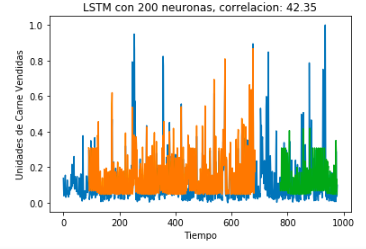

- Error:
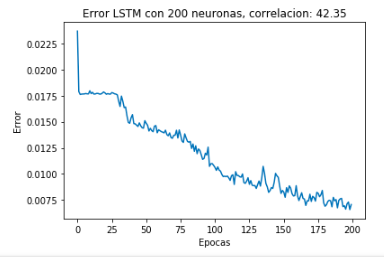

685 294
Epoch 1/200
 - 29s - loss: 0.0237
Epoch 2/200
 - 5s - loss: 0.0179
Epoch 3/200
 - 5s - loss: 0.0176
Epoch 4/200
 - 4s - loss: 0.0176
Epoch 5/200
 - 4s - loss: 0.0177
Epoch 6/200
 - 5s - loss: 0.0177
Epoch 7/200
 - 4s - loss: 0.0177
Epoch 8/200
 - 4s - loss: 0.0177
Epoch 9/200
 - 4s - loss: 0.0177
Epoch 10/200
 - 4s - loss: 0.0180
Epoch 11/200
 - 4s - loss: 0.0177
Epoch 12/200
 - 4s - loss: 0.0178
Epoch 13/200
 - 4s - loss: 0.0176
Epoch 14/200
 - 4s - loss: 0.0177
Epoch 15/200
 - 4s - loss: 0.0177
Epoch 16/200
 - 4s - loss: 0.0177
Epoch 17/200
 - 4s - loss: 0.0176
Epoch 18/200
 - 4s - loss: 0.0176
Epoch 19/200
 - 4s - loss: 0.0177
Epoch 20/200
 - 4s - loss: 0.0178
Epoch 21/200
 - 4s - loss: 0.0178
Epoch 22/200
 - 4s - loss: 0.0176
Epoch 23/200
 - 5s - loss: 0.0177
Epoch 24/200
 - 4s - loss: 0.0177
Epoch 25/200
 - 5s - loss: 0.0176
Epoch 26/200
 - 5s - loss: 0.0178
Epoch 27/200
 - 4s - loss: 0.0177
Epoch 28/200
 - 4s - loss: 0.0177
Epoch 29/200
 - 5s - loss: 0.0176
Epoch 30/200
 

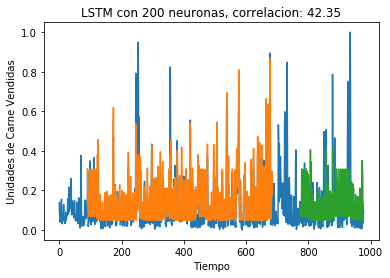

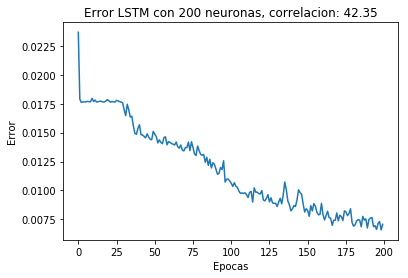

In [10]:
## EJECUCIÓN DE LA FUNCIÓN DE CONSTRUCCIÓN, ENTRENAMIENTO Y TEST DE LA RED
execute_lstm(unidades, date, look_back=90, neuronas=200, epocas=200, capas=6, training_split=0.7,optimizacion='adam', act='tanh')

## ARQUITECTURA NEURONAL 
- Ventana de tiempo (look_back) de 6 meses
- 200 neuronas
- 200 epocas de entrenamiento
- Función de optimización adam
- Función de activación tanh
- Entrenamiento y test: 
    - Validación cruzada 70% - 30%

### Resultado:
- Correlación de un 49.20%
- Modelo:
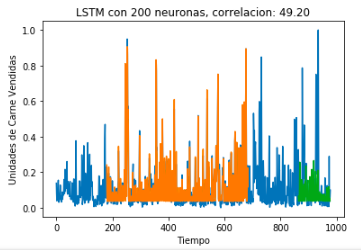

- Error: 
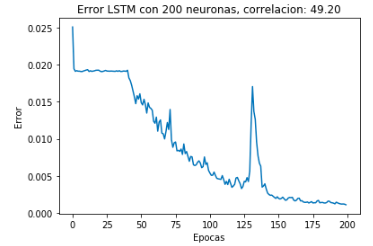

685 294
Epoch 1/200
 - 25s - loss: 0.0251
Epoch 2/200
 - 3s - loss: 0.0195
Epoch 3/200
 - 3s - loss: 0.0191
Epoch 4/200
 - 3s - loss: 0.0192
Epoch 5/200
 - 4s - loss: 0.0191
Epoch 6/200
 - 3s - loss: 0.0191
Epoch 7/200
 - 3s - loss: 0.0191
Epoch 8/200
 - 4s - loss: 0.0191
Epoch 9/200
 - 4s - loss: 0.0192
Epoch 10/200
 - 3s - loss: 0.0192
Epoch 11/200
 - 4s - loss: 0.0193
Epoch 12/200
 - 5s - loss: 0.0193
Epoch 13/200
 - 5s - loss: 0.0191
Epoch 14/200
 - 5s - loss: 0.0192
Epoch 15/200
 - 4s - loss: 0.0191
Epoch 16/200
 - 4s - loss: 0.0191
Epoch 17/200
 - 4s - loss: 0.0192
Epoch 18/200
 - 4s - loss: 0.0192
Epoch 19/200
 - 4s - loss: 0.0193
Epoch 20/200
 - 3s - loss: 0.0193
Epoch 21/200
 - 3s - loss: 0.0191
Epoch 22/200
 - 3s - loss: 0.0191
Epoch 23/200
 - 4s - loss: 0.0191
Epoch 24/200
 - 3s - loss: 0.0192
Epoch 25/200
 - 3s - loss: 0.0192
Epoch 26/200
 - 4s - loss: 0.0191
Epoch 27/200
 - 4s - loss: 0.0191
Epoch 28/200
 - 4s - loss: 0.0191
Epoch 29/200
 - 4s - loss: 0.0191
Epoch 30/200
 

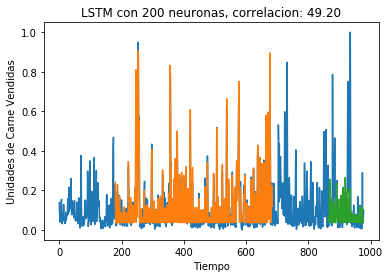

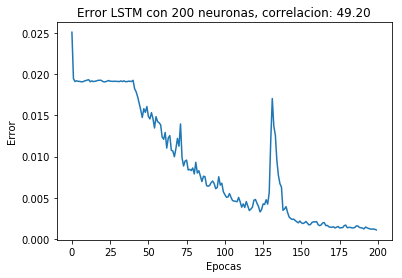

In [11]:
## EJECUCIÓN DE LA FUNCIÓN DE CONSTRUCCIÓN, ENTRENAMIENTO Y TEST DE LA RED
execute_lstm(unidades, date, look_back=180, neuronas=200, epocas=200, capas=6, training_split=0.7,optimizacion='adam', act='tanh')

## 

## ARQUITECTURA NEURONAL 
- Ventana de tiempo (look_back) de 3 meses
- 200 neuronas
- 200 epocas de entrenamiento
- Función de optimización adam
- Función de activación tanh
- Entrenamiento y test: 
    - Validación cruzada 70% - 30%

### Resultado:
- Correlación de un 27.31%
- Modelo:
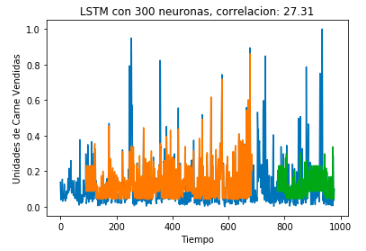

- Error: 
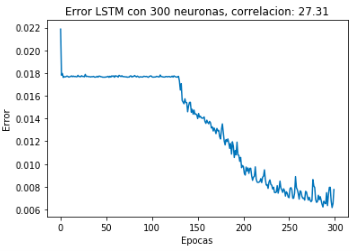

685 294
Epoch 1/300
 - 46s - loss: 0.0245
Epoch 2/300
 - 7s - loss: 0.0191
Epoch 3/300
 - 7s - loss: 0.0192
Epoch 4/300
 - 8s - loss: 0.0191
Epoch 5/300
 - 7s - loss: 0.0191
Epoch 6/300
 - 6s - loss: 0.0191
Epoch 7/300
 - 6s - loss: 0.0191
Epoch 8/300
 - 7s - loss: 0.0191
Epoch 9/300
 - 6s - loss: 0.0192
Epoch 10/300
 - 6s - loss: 0.0192
Epoch 11/300
 - 6s - loss: 0.0193
Epoch 12/300
 - 7s - loss: 0.0191
Epoch 13/300
 - 8s - loss: 0.0191
Epoch 14/300
 - 7s - loss: 0.0191
Epoch 15/300
 - 7s - loss: 0.0191
Epoch 16/300
 - 8s - loss: 0.0191
Epoch 17/300
 - 8s - loss: 0.0191
Epoch 18/300
 - 7s - loss: 0.0192
Epoch 19/300
 - 6s - loss: 0.0191
Epoch 20/300
 - 7s - loss: 0.0191
Epoch 21/300
 - 6s - loss: 0.0191
Epoch 22/300
 - 8s - loss: 0.0192
Epoch 23/300
 - 8s - loss: 0.0193
Epoch 24/300
 - 8s - loss: 0.0191
Epoch 25/300
 - 8s - loss: 0.0192
Epoch 26/300
 - 8s - loss: 0.0194
Epoch 27/300
 - 8s - loss: 0.0192
Epoch 28/300
 - 9s - loss: 0.0192
Epoch 29/300
 - 8s - loss: 0.0192
Epoch 30/300
 

 - 7s - loss: 6.0946e-04
Epoch 236/300
 - 7s - loss: 6.0096e-04
Epoch 237/300
 - 6s - loss: 5.9209e-04
Epoch 238/300
 - 6s - loss: 4.9283e-04
Epoch 239/300
 - 7s - loss: 4.4324e-04
Epoch 240/300
 - 8s - loss: 5.1291e-04
Epoch 241/300
 - 7s - loss: 7.3138e-04
Epoch 242/300
 - 6s - loss: 8.5020e-04
Epoch 243/300
 - 6s - loss: 0.0011
Epoch 244/300
 - 7s - loss: 0.0011
Epoch 245/300
 - 6s - loss: 7.8062e-04
Epoch 246/300
 - 8s - loss: 6.7599e-04
Epoch 247/300
 - 7s - loss: 7.7694e-04
Epoch 248/300
 - 6s - loss: 7.8493e-04
Epoch 249/300
 - 7s - loss: 7.1485e-04
Epoch 250/300
 - 7s - loss: 8.1779e-04
Epoch 251/300
 - 7s - loss: 6.5855e-04
Epoch 252/300
 - 9s - loss: 5.1432e-04
Epoch 253/300
 - 9s - loss: 5.2718e-04
Epoch 254/300
 - 11s - loss: 3.8694e-04
Epoch 255/300
 - 7s - loss: 4.0867e-04
Epoch 256/300
 - 7s - loss: 3.8458e-04
Epoch 257/300
 - 6s - loss: 4.4437e-04
Epoch 258/300
 - 6s - loss: 4.5350e-04
Epoch 259/300
 - 7s - loss: 4.5049e-04
Epoch 260/300
 - 7s - loss: 4.3760e-04
Epoch 2

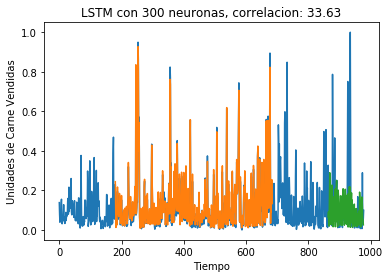

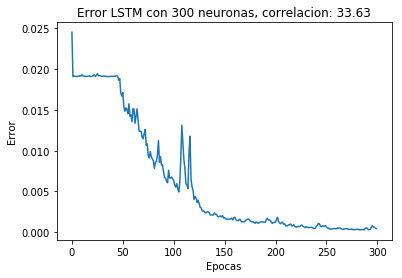

(<keras.engine.sequential.Sequential at 0x1a737c56d8>, array([[0.24393699],
        [0.10960165],
        [0.01246201],
        [0.06072441],
        [0.03938556],
        [0.02477051],
        [0.13530518],
        [0.21703245],
        [0.08111197],
        [0.09297812],
        [0.08436394],
        [0.06756962],
        [0.08874981],
        [0.18461196],
        [0.18213235],
        [0.09787331],
        [0.0384469 ],
        [0.03237284],
        [0.0476071 ],
        [0.10829584],
        [0.17386389],
        [0.09365351],
        [0.08682987],
        [0.02431756],
        [0.050698  ],
        [0.02568888],
        [0.05545476],
        [0.06091909],
        [0.10283457],
        [0.1013932 ],
        [0.02013931],
        [0.10993737],
        [0.05367865],
        [0.07785369],
        [0.06776077],
        [0.10056414],
        [0.11884747],
        [0.03078058],
        [0.05916169],
        [0.04618275],
        [0.1303752 ],
        [0.1757747 ],
        [0.34117937],


In [101]:
## EJECUCIÓN DE LA FUNCIÓN DE CONSTRUCCIÓN, ENTRENAMIENTO Y TEST DE LA RED
execute_lstm(unidades, date, look_back=180, neuronas=300, epocas=300, capas=6, training_split=0.7,optimizacion='adam', act='tanh')
##

## PREDICCIÓN
- Haciendo uso del mejor modelo (de acuerdo a correlación y estabilidad) 


685 294
Epoch 1/200
 - 35s - loss: 0.0236
Epoch 2/200
 - 4s - loss: 0.0177
Epoch 3/200
 - 4s - loss: 0.0177
Epoch 4/200
 - 4s - loss: 0.0177
Epoch 5/200
 - 4s - loss: 0.0177
Epoch 6/200
 - 4s - loss: 0.0177
Epoch 7/200
 - 4s - loss: 0.0177
Epoch 8/200
 - 4s - loss: 0.0179
Epoch 9/200
 - 4s - loss: 0.0177
Epoch 10/200
 - 4s - loss: 0.0177
Epoch 11/200
 - 4s - loss: 0.0179
Epoch 12/200
 - 4s - loss: 0.0178
Epoch 13/200
 - 4s - loss: 0.0176
Epoch 14/200
 - 4s - loss: 0.0177
Epoch 15/200
 - 4s - loss: 0.0178
Epoch 16/200
 - 4s - loss: 0.0176
Epoch 17/200
 - 4s - loss: 0.0177
Epoch 18/200
 - 5s - loss: 0.0177
Epoch 19/200
 - 5s - loss: 0.0177
Epoch 20/200
 - 4s - loss: 0.0176
Epoch 21/200
 - 5s - loss: 0.0179
Epoch 22/200
 - 5s - loss: 0.0177
Epoch 23/200
 - 5s - loss: 0.0178
Epoch 24/200
 - 4s - loss: 0.0179
Epoch 25/200
 - 4s - loss: 0.0176
Epoch 26/200
 - 4s - loss: 0.0177
Epoch 27/200
 - 4s - loss: 0.0177
Epoch 28/200
 - 4s - loss: 0.0176
Epoch 29/200
 - 4s - loss: 0.0176
Epoch 30/200
 

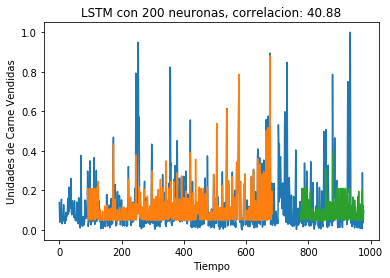

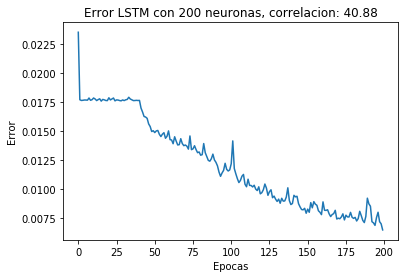

In [176]:
## EJECUCIÓN DE LA FUNCIÓN DE CONSTRUCCIÓN, ENTRENAMIENTO Y TEST DE LA RED
model1, trainPredict1, testPredict1, scaler1 = execute_lstm(unidades, date, look_back=90, neuronas=200, epocas=200, capas=6, training_split=0.7,optimizacion='adam', act='tanh')

#

In [228]:
# DATOS DEL MES DE NOVIEMBRE A PREDECIR
predict_data1 = pandas.read_csv('./INPUT_DATA_PREDICT.CSV')
scaler = MinMaxScaler(feature_range=(0, 1))
unidades1 = scaler.fit_transform(unidades)

In [229]:
predict_data1 = predict_data1.values
predict_data1 = predict_data1.astype('float32')

In [230]:
#se define lookback igual al usado en modelo neuronal
look_back1 = 90
predict_data_lookback1, predict_data_tiempo_actual1  = create_dataset(predict_data1, look_back1) 

In [231]:
predict_data_lookback1 = numpy.reshape(predict_data_lookback1, (predict_data_lookback1.shape[0], 1, predict_data_lookback1.shape[1]))
#Predicción
predict_model1 = model.predict(predict_data_lookback1)



In [232]:
trainPredictPlot = numpy.empty_like(unidades)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back1:len(trainPredict) + look_back1, :] = trainPredict

In [233]:
testPredictPlot = numpy.empty_like(unidades)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict) + (look_back1 * 2) - 1 :len(unidades) - 1, :] = testPredict

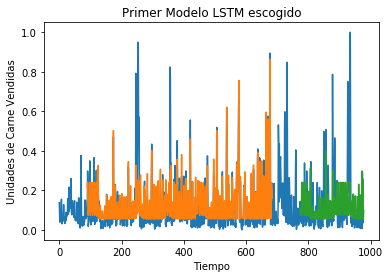

In [234]:
plt.plot(unidades1)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.title("Primer Modelo LSTM escogido")
plt.ylabel("Unidades de Carne Vendidas")
plt.xlabel("Tiempo")
plt.show()